In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Monitoring for batch prediction in AutoML image models

<table align="left">
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/get_started_with_model_monitoring_automl_image_batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    
  <td>
        <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/get_started_with_model_monitoring_automl_image_batch.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
        </a>
  </td>
    
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/model_monitoring/get_started_with_model_monitoring_automl_image_batch.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
    
</table>
<br/><br/><br/>

## Overview


This tutorial demonstrates how to use Vertex AI Model Monitoring for AutoML image models.

Learn more about [Vertex AI Model Monitoring](https://cloud.google.com/vertex-ai/docs/model-monitoring).

### Objective

In this tutorial, you learn how to use `Vertex AI Model Monitoring` with `Vertex AI Batch Prediction` with an AutoML image classification model to detect an out of distribution image.


Due to lack of unlabeled samples, AutoML image classification model is prone to classifiy out of distribution image into one of the labeled class in training dataset thus making **False Positive** prediction. With `Vertex AI Model Monitoring` you can detect and identify prediction requests that contain out of distribution images.

This tutorial uses the following Google Cloud ML services:

- `AutoML`
- `Vertex AI Batch Prediction`
- `Vertex AI Model Monitoring`

The steps performed include:

1. Train an AutoML image classification model.
2. Submit a batch prediction containing both in and out of distribution images.
3. Use Model Monitoring to calculate anomaly score on each image.
4. Identify the images in the batch prediction request that are out of distribution.

### Term & Concept

**Anomaly Score**:
1. Normalized distance to training dataset using properitary model, above 3 can be deemed as outlier. (__similair to z-score in statistics__)

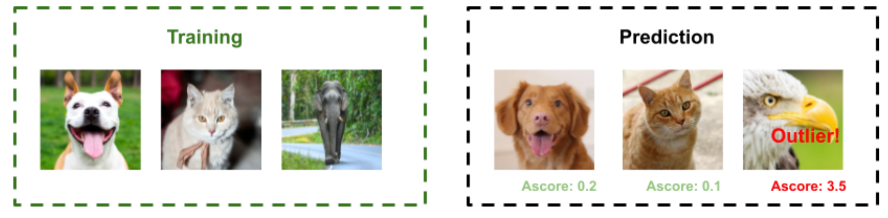

## Main Function

1. Produce an **Anomaly Score** for each prediction image.
2. Checkout nearst neighbor of prediction image in training dataset using the properiatery model.
3. Log prediction output and monitoring result into an unified BigQuery table.
  1. Have anomaly score and prediction result.
  2. Have batch/online information

## Value & Usage
Model researchers:
1. Can query images by normalized anomaly score to re-label and retrain the model instead of randomly check every image.
  1. Use KNN to find out which training has shortest normalized distance to understand how anomaly score is derived.
2. Do joint analysis between custom trained classification model and Google's properiatery model. (e.g Query by high anomaly score and high confidence score to understand false positive predictions.)

Model ops:
1. Setup custom alert by reading average anomaly score across time at BigQuery thus monitoring prediction data quality.

### Dataset

The image dataset used for this tutorial is the [Flowers dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset in this tutorial is stored in a public Cloud Storage bucket. The trained model predicts the type of flower in a given image from a class of five flowers: daisy, dandelion, rose, sunflower, or tulip.

### Costs
This tutorial uses billable components of Google Cloud:

- Vertex AI
- Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage pricing](https://cloud.google.com/storage/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installations

Install the following packages for further running this notebook.

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

# Install the packages
! pip3 install {USER_FLAG} -q --upgrade google-cloud-aiplatform \
                                        google-cloud-storage \
                                        pandas-gbq

! pip3 install {USER_FLAG} -q -U google-cloud-aiplatform "shapely<2" \
                                 tensorflow==2.7 \
                                 google-api-core==2.10

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Compute Engine, Cloud Storage and Cloud Logging APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage_component,logging).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [ ]:
! gcloud config set project $PROJECT_ID

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

#### User Email

Set your user email address to receive monitoring alerts.

In [ ]:
USER_EMAIL = "[your-email-address]"  # @param {type:"string"}

if os.getenv("IS_TESTING"):
    USER_EMAIL = "noreply@google.com"

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

1. **Click Create service account**.

2. In the **Service account name** field, enter a name, and click **Create**.

3. In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

4. Click Create. A JSON file that contains your key downloads to your local environment.

5. Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex AI SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + UUID
    BUCKET_URI = "gs://" + BUCKET_NAME

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

### Import libraries 

In [ ]:
import google.cloud.aiplatform as aiplatform
import pandas as pd
from google.cloud.aiplatform import model_monitoring

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION)

#### Location of Cloud Storage training data.

Now set the variable `IMPORT_FILE` to the location of the CSV index file in Cloud Storage.

In [ ]:
IMPORT_FILE = (
    "gs://cloud-samples-data/vision/automl_classification/flowers/all_data_v2.csv"
)

#### Quick peek at your data

This tutorial uses a version of the Happy Moments dataset that is stored in a public Cloud Storage bucket, using a CSV index file.

Start by doing a quick peek at the data. You count the number of examples by counting the number of rows in the CSV index file  (`wc -l`) and then peek at the first few rows.

In [ ]:
FILE = IMPORT_FILE

count = ! gsutil cat $FILE | wc -l
print("Number of Examples", int(count[0]))

print("First 10 rows")
! gsutil cat $FILE | head

### Create the Dataset

Next, create the `Dataset` resource using the `create` method for the `ImageDataset` class, which takes the following parameters:

- `display_name`: The human readable name for the `Dataset` resource.
- `gcs_source`: A list of one or more dataset index files to import the data items into the `Dataset` resource.
- `import_schema_uri`: The data labeling schema for the data items:
  - `single_label`: Binary and multi-class classification
  - `multi_label`: Multi-label multi-class classification
  - `bounding_box`: Object detection
  - `image_segmentation`: Segmentation

Learn more about [ImageDataset](https://cloud.google.com/vertex-ai/docs/datasets/prepare-image).

In [ ]:
dataset = aiplatform.ImageDataset.create(
    display_name="flowers_" + UUID,
    gcs_source=[IMPORT_FILE],
    import_schema_uri=aiplatform.schema.dataset.ioformat.image.single_label_classification,
)

print(dataset.resource_name)

### Create and run training pipeline

To train an AutoML model, you perform two steps: 1) create a training pipeline, and 2) run the pipeline.

#### Create training pipeline

An AutoML training pipeline is created with the `AutoMLImageTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `prediction_type`: The type task to train the model for.
  - `classification`: An image classification model.
  - `object_detection`: An image object detection model.
- `multi_label`: If a classification task, whether single (`False`) or multi-labeled (`True`).
- `model_type`: The type of model for deployment.
  - `CLOUD`: Deployment on Google Cloud
  - `CLOUD_HIGH_ACCURACY_1`: Optimized for accuracy over latency for deployment on Google Cloud.
  - `CLOUD_LOW_LATENCY_`: Optimized for latency over accuracy for deployment on Google Cloud.
  - `MOBILE_TF_VERSATILE_1`: Deployment on an edge device.
  - `MOBILE_TF_HIGH_ACCURACY_1`:Optimized for accuracy over latency for deployment on an edge device.
  - `MOBILE_TF_LOW_LATENCY_1`: Optimized for latency over accuracy for deployment on an edge device.
- `base_model`: (optional) Transfer learning from existing `Model` resource -- supported for image classification only.

The instantiated object is the DAG (directed acyclic graph) for the training job.

In [ ]:
dag = aiplatform.AutoMLImageTrainingJob(
    display_name="flowers_" + UUID,
    prediction_type="classification",
    multi_label=False,
    model_type="CLOUD",
    base_model=None,
)

print(dag)

#### Run the training pipeline

Next, you run the created DAG to start the training job by invoking the method `run`, with the following parameters:

- `dataset`: The `Dataset` resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).
- `validation_fraction_split`: The percentage of the dataset to use for validation.
- `budget_milli_node_hours`: (optional) Maximum training time specified in unit of milli node-hours (1000 = node-hour).
- `disable_early_stopping`: If `True`, training maybe completed before using the entire budget if the service believes it cannot further improve on the model objective measurements.

The `run` method when completed returns the `Model` resource.

The execution of the training pipeline will take upto 2 hrs.

In [ ]:
model = dag.run(
    dataset=dataset,
    model_display_name="flowers_" + UUID,
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    budget_milli_node_hours=8000,
    disable_early_stopping=False,
)

## Introduction to Batch Prediction

Batch prediction provides the ability to do offline batch processing of large amounts of prediction requests. Resources are only provisioned during the batch process and then deprovisioned when the batch request is completed. The results are stored in Cloud Storage, in contrast to online prediction where the results are returned as a HTTP response packet.

The input format for your batch job is dependent on the format supported by your model server. Foremost, the web server in your model server must support a JSONL format, which the web server converts to a format support either directly by the model input intertace or a serving function interface. For batch prediction, this JSONL format is referred to as the `pivot` format.

### Input format for batch prediction jobs


The batch server accepts the following input formats for AutoML image models:

- JSONL

### Output format for batch prediction jobs

The batch server accepts the following output formats for AutoML image models:

- JSONL

## Send a batch prediction request

Send a batch prediction to your deployed model.

### Make batch file

#### Batch data assembly

Next, you construct the batch request file. The prepared batch request file has a collection of flower images (in-distribution) and dog images (out-of-distribution).

Each entry is in the form:

```
{"content": cloud-samples-data/vertex-ai/model-monitoring/flowers_anomaly_dog/image_02300.jpg", "mimeType": "image/jpeg"}
```

Currently, the sampled batch data is stored in a public multi-region (e.g. US) bucket. For Vertex AI Batch Prediction, the data needs to be copied over to a single region bucket (e.g., us-central1).

Next, you copy the data to your Cloud Storage bucket, and update the paths in the batch file accordingly.

#### Batch file contents

The batch file contains the following 10 images:
- 6 daisy flower images
- 2 passion flower images (out of distribution)
- 2 dog images (out of distribution)

In [ ]:
SAMPLE_BATCH_DATA = (
    "gs://cloud-samples-data/vertex-ai/model-monitoring/flowers_anomaly_dog/"
)
USER_BATCH_DATA = BUCKET_URI + "/batch_data/"
! gsutil cp -r {SAMPLE_BATCH_DATA} {USER_BATCH_DATA}

SAMPLE_BATCH_FILE = (
    "gs://cloud-samples-data/vertex-ai/model-monitoring/flowers_anomaly_dog/batch.jsonl"
)
USER_BATCH_FILE = USER_BATCH_DATA + "/flowers_anomaly_dog/batch.jsonl"
! gsutil cp {SAMPLE_BATCH_FILE} tmp.jsonl
SCRIPT = f"s#{SAMPLE_BATCH_DATA}#{USER_BATCH_DATA}flowers_anomaly_dog/#g"
! sed $SCRIPT tmp.jsonl >batch.jsonl
! gsutil cp batch.jsonl {USER_BATCH_FILE}

### Create batch prediction job

This step parameterizes and builds the data structure representing the batch prediction request, with model monitoring enabled.

The BatchPredictionJob object specifies the input source, the data format, and the computing resources requests for the batch prediction. Learn more about <a href="https://cloud.google.com/vertex-ai/docs/samples/aiplatform-create-batch-prediction-job-sample" target="_blank">BatchPredictionJob</a>.

The ModelMonitoringConfig object specifies the alerting email address, the training dataset, the features to be monitored, and their associated alerting thresholds. Learn more about <a href="https://cloud.google.com/vertex-ai/docs/model-monitoring" target="_blank">ModelMonitoringConfig</a>.

In [ ]:
OUTPUT_URI = BUCKET_URI + "/batch_results"
MODEL_NAME = model.resource_name

from google.cloud.aiplatform_v1beta1.types import (
    BatchDedicatedResources, BatchPredictionJob, GcsDestination, GcsSource,
    MachineSpec, ModelMonitoringAlertConfig, ModelMonitoringConfig,
    ModelMonitoringObjectiveConfig, ThresholdConfig)

batch_prediction_job = BatchPredictionJob(
    display_name="flowers_" + UUID,
    model=MODEL_NAME,
    input_config=BatchPredictionJob.InputConfig(
        instances_format="jsonl", gcs_source=GcsSource(uris=[USER_BATCH_FILE])
    ),
    output_config=BatchPredictionJob.OutputConfig(
        predictions_format="jsonl",
        gcs_destination=GcsDestination(output_uri_prefix=OUTPUT_URI),
    ),
    dedicated_resources=BatchDedicatedResources(
        machine_spec=MachineSpec(machine_type="n1-standard-8"),
        starting_replica_count=1,
        max_replica_count=1,
    ),
    # Model monitoring service will be triggerred if provide following configs.
    model_monitoring_config=ModelMonitoringConfig(
        alert_config=ModelMonitoringAlertConfig(
            email_alert_config=ModelMonitoringAlertConfig.EmailAlertConfig(
                user_emails=[USER_EMAIL]
            )
        ),
        objective_configs=[
            ModelMonitoringObjectiveConfig(
                training_prediction_skew_detection_config=ModelMonitoringObjectiveConfig.TrainingPredictionSkewDetectionConfig(
                    default_skew_threshold=ThresholdConfig(value=2),
                )
            )
        ],
    ),
)

### Submit batch prediction job

This step submits the batch prediction request created in the previous step. If successful, it returns a JSON document summarizing the request, which is displayed in the cell output below.

In [ ]:
from google.cloud.aiplatform_v1beta1.services.job_service import \
    JobServiceClient

API_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"
client = JobServiceClient(client_options={"api_endpoint": API_ENDPOINT})
out = client.create_batch_prediction_job(
    parent=f"projects/{PROJECT_ID}/locations/{REGION}",
    batch_prediction_job=batch_prediction_job,
)
BATCH_PREDICTION_JOB_ID = out.name.split("/")[-1]
print("BATCH_PREDICTION_JOB_ID:", BATCH_PREDICTION_JOB_ID)

## Wait for prediction results

The batch prediction request will be completed after about **25 mins**, and the model monitoring result will be available **10 mins** after that. The request below obtains the batch prediction job id, which is a unique number associated with asynchronous requests like this one.

*Note:* On the first monitoring trial, the wait time for the monitoring results to be available is approximately **30 mins**, in which a cached image index for the model is built.

In [ ]:
import time

# If auto-testing, wait for request completion
if os.getenv("IS_TESTING"):
    time.sleep(60 * 60)

## Check 1: Check Outliers From BigQuery

First, you define some helper functions:

- `get_batch_prediction_anomaly_scores`: Get anomaly scores per image for the batch prediction from the corresponding BigQuery anomaly score table.
- `plot_outlier_images`: Plot the top (greatest) outlier images.

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


def plot_outlier_images(data: pd.DataFrame, col_num: int = 4) -> None:
    row_num = int((data.shape[0] - 1) / col_num) + 1
    plot, axes = plt.subplots(row_num, col_num, figsize=(8 * col_num, 7 * row_num))
    if row_num == 1:
        axes = [axes]
    print(row_num, col_num)
    for idx, row in data.reset_index().iterrows():
        ax = axes[int(idx / col_num)][int(idx % col_num)]
        ax.imshow(mpimg.imread(tf.io.gfile.GFile(row["image_gcs_uri"], "rb")))
        ax.title.set_text(
            "{} \n automl_prediciton: {}, automl condifence: {} \n normalized anomaly score: {}, anomaly score: {}".format(
                row["image_id"],
                row["classification"],
                round(row["confidence_score"], 2),
                round(row["normalized_score"], 2),
                round(row["score"], 2),
            )
        )


def get_batch_prediction_anomaly_scores(
    batch_prediction_job_id: int,
    limits: int = 20,
    ascore_threshold: float = 2,
    ascending: bool = False,
    greater: bool = True,
) -> pd.DataFrame:
    TABLE_NAME = (
        f"{PROJECT_ID}.vertex_ai_model_monitoring.image_classification_anomaly_scores"
    )
    SELECT_COLUMNS = [
        "image_id",
        "record_time",
        "prediction_result.confidence_score",
        "prediction_result.classification",
        "anomaly_score_result.score",
        "anomaly_score_result.normalized_score",
        "nearest_neighbor",
        "metadata.image_gcs_uri",
    ]
    query_string = (
        f"""SELECT {','.join(SELECT_COLUMNS)}"""
        f""" FROM `{TABLE_NAME}`"""
        f""" WHERE metadata.batch_prediction_job_id = {batch_prediction_job_id}"""
        f""" AND anomaly_score_result.normalized_score {">" if greater else "<"} {ascore_threshold}"""
        f""" ORDER BY anomaly_score_result.normalized_score {"" if ascending else "DESC"}"""
        f""" LIMIT {limits}"""
    )
    print(query_string)
    return pd.read_gbq(query_string, project_id=PROJECT_ID, location=REGION)

#### Get the anomaly scores

Get the anomaly scores, ranked by greatest. Then display the top four.

In [ ]:
scores = get_batch_prediction_anomaly_scores(
    BATCH_PREDICTION_JOB_ID, ascore_threshold=3
)

scores.iloc[:4]

#### Plot the outlier images

Next, you plot (display) the top outlier images.

Notice that the four outlier images are the four out of distribution in the batch job - 2 passion flower, and 2 dog images.

In [ ]:
plot_outlier_images(scores)

## Check 2: Check KNN for the Image

### Get ID of greatest outlier

Next, you get the image id of the image that has the greatest outlier value.

In [ ]:
image_id = scores.iloc[:4]["image_id"][0]

### KNN of outliers

Plot images similiar (nearest neighbor) from the `training dataset` to the outlier.

In [ ]:
def plot_knn_images(data: pd.DataFrame, image_id, col_num: int = 4) -> None:
    image_row = data.loc[data.image_id == image_id].iloc[0]
    total_image_number = len(image_row.nearest_neighbor) + 1
    row_num = int((total_image_number - 1) / col_num) + 1
    plot, axes = plt.subplots(row_num, col_num, figsize=(8 * col_num, 7 * row_num))
    if row_num == 1:
        axes = [axes]
    print(row_num, col_num)

    # Print prediction image.
    ax = axes[0][0]
    ax.imshow(mpimg.imread(tf.io.gfile.GFile(image_row["image_gcs_uri"], "rb")))
    ax.title.set_text(
        "{} \n automl_prediciton: {}, automl confidence: {} \n normalized anomaly score: {}, anomaly score: {}".format(
            image_row["image_id"],
            image_row["classification"],
            round(image_row["confidence_score"], 2),
            round(image_row["normalized_score"], 2),
            round(image_row["score"], 2),
        )
    )

    for _idx, row in enumerate(image_row.nearest_neighbor):
        idx = _idx + 1
        ax = axes[int(idx / col_num)][int(idx % col_num)]
        ax.imshow(mpimg.imread(tf.io.gfile.GFile(row["image_id"], "rb")))
        ax.title.set_text(
            "{} \n normalized_distance: {}".format(
                "/".join(row["image_id"].split("/")[-2:]),
                round(row["normalized_distance"], 2),
            )
        )


plot_knn_images(scores, image_id, col_num=3)

## KNN of non outliers

As a comparison, non-outliers has low anomaly score and is correctly identified as daisy by AutoMl model. It has a lot of similar pictures in the training dataset.

In [ ]:
no_scores = get_batch_prediction_anomaly_scores(
    BATCH_PREDICTION_JOB_ID,
    ascore_threshold=4,
    greater=False,
    limits=1000,
    ascending=True,
)
no_scores.iloc[:3]

### Get ID of least outlier

Next, you get the image id of the image that has the least outlier value.

In [ ]:
image_id = no_scores.iloc[:4]["image_id"][0]
image_id

### Plot KNN of non-outlier

Plot images similiar (nearest neighbor) to the least outlier. 

Notice, the similiar images from the `training data` are also daisy flowers.

In [ ]:
plot_knn_images(no_scores, image_id, col_num=2)

# Check 3: Check email

The batch prediction monitoring will send you an email if any outliers are found.

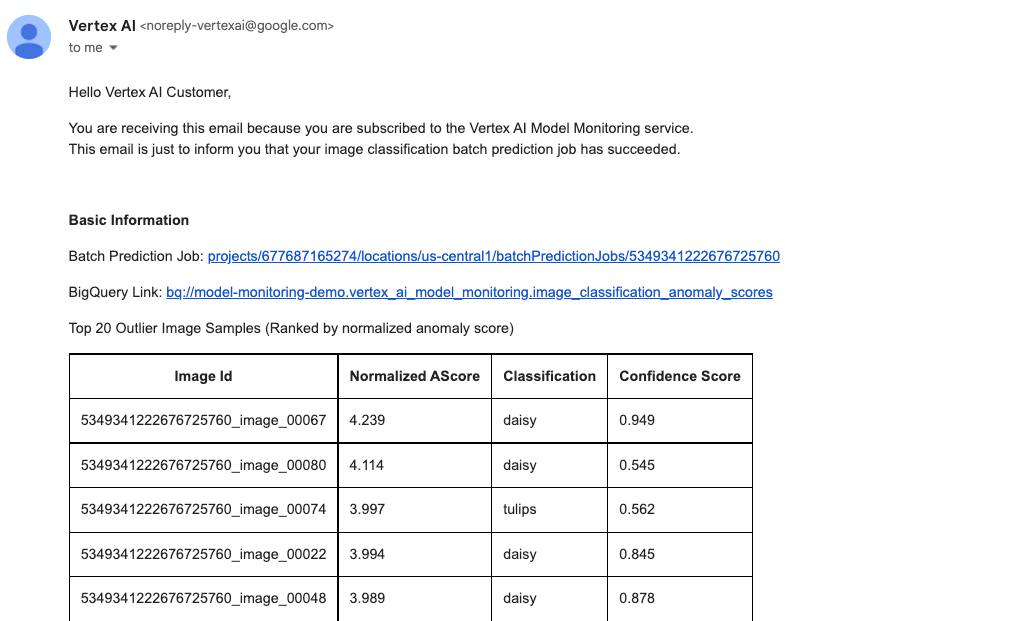

## Cleanup

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial

In [ ]:
delete_bucket = False

try:
    dataset.delete()
    model.delete()
except:
    pass


try:
    jobs = aiplatform.BatchPredictionJob.list(filter=f"display_name=flowers_{UUID}")
    jobs[0].delete()
except:
    pass

# delete BQ table
! bq rm -r -f {PROJECT_ID}.vertex_ai_model_monitoring

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}